In [ ]:
#!pip install numpy
#!pip install sklearn
!pip install ipympl

In [246]:
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import os
from ipywidgets import interact

In [247]:
from IPython.core.display import HTML
HTML("""
<style>
.consignes{
  font-weight: bold;
  color: #3256a8;
  background-color: #edebdf
}
</style>
""")



# TP2: Détection de menaces radar

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom, affectation).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp2.ipynb 

2 séances de TP sur ce sujet : le 16 octobre (1h30) et le 23 octobre (3h).<br> 
Deadline : 30 otobre 2024, 13h59, par mail à deepetsignal.mva@gmail.com <br> 

Pour installer les paquets nécessaires à la réalisation de ce TP vous pouvez utiliser dans le notebook 
    
```
!pip install \< nom_du_paquet \>
```
merci de regrouper toutes les installations dans la première cellule du notebook. 
Essayez de faire en sorte que votre notebook puisse se lire comme un compte rendu, évitez de laisser du code mort et prennez le temps de commenter vos observations et résultats.
    
## Mission


Vous commandez un avion de reconnaissance en mission top secrète. Malgré votre discretion et toutes les précautions prises vous dérangez et pouvez être sujet de menaces qu'il vous faut détecter pour garantir la sécurité de votre équipage et la succès de votre mission (comme elle est top secrète vous ne pouvez pas en savoir plus). 

A votre disposition un réseau d'antennes et un système d'analyse spectrale perfectionnés vous permettent d'extraire et de caractériser des signaux en provenance des radars à altitude 0 qui parsèment votre parcours. 

Un signal radar est composé d'impulsions. Le système d'analyse vous permettent de caractériser chaque impulsion reçue par un PDW (Pulse Description Word) qui contient: 

- la date de début de détection de l'impulsion (en ms)
- la largeur ou durée de l'impulsion (en ms)
- la puissance de l'impulsion (en dB / référence) 
- l'angle theta et l'angle phi décrivant la direction dans laquelle l'impulsion est détectée (en radians)
- la fréquence de l'impulsion (en Ghz)

Votre capteur n'est pas parfait et vous subissez notamment un phénomène de mitage: une certaine proportion des impulsions émises ne sont pas détectées. Cette proportion est d'autant plus grande que la puissance des impulsions est petite.  

Votre vaisseau navigue à 10 km d'altitude, avec une vitesse constante de 1000 km/h vers le nord. 

De précédentes missions ont permis de réaliser une base de données de signaux de 10 secondes. 
Chaque signal se présente sous la forme d'un fichier .npz qui contient l'ensemble des PDW reçus. 

Un signal est donc un fichier dont le nom est de la forme 'pdw_<numéro du signal>.npz'.

Cette base de données est annotée: le destin de chaque mission a permis de déclarer chaque signal comme une 'menace' ou une 'nonmenace'. 

Les signaux ont été divisés en deux ensembles indépendants: 
    
- train
- test 
 
Les annotations pour chaque ensemble sont disponibles dans le fichier labels_<train ou test>.json qui donne l'association nom de fichier -> menace ou nonmenace. 
    
    
Votre mission (si vous l'acceptez) est de choisir et d'entrainer un algorithme d'apprentissage machine à détecter les menaces sur l'ensemble 'train' et à évaluer ses performances sur l'ensemble 'test'. 

Fort de votre expérience passée, vous décidez de suivre la méthodologie suivante: 

- Visualisation et analyse des données pour trouver les paramètres les plus pertinents à utiliser 
- Sélection d'un algorithme naïf "baseline" de référence: vous définissez un premier algorithme simple et caractérisez ses performances qui serviront de point de comparaison pour qualifier l'apport d'algorithmes plus sophistiqués 
- Vous utilisez la bibliothèque sklearn et notamment ses implémentations d'algorithmes de classification binaire pour définir et entrainer sur l'ensemble 'train' un ou plusieurs algorithmes en capacité de prédire le label menance ou nonmenace de chaque signal (https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
- Vous qualifiez les performances de vos algorithmes en termes d'accuracy (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) ; vous calculez aussi les matrices de confusion (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
    
Pour ce TP nous ne cherchons pas à mettre en place des algorithmes d'apprentissage profond. Ces méthodes pourront être investiguées dans un deuxième temps.
    
 Si les résultats vous semblent décevants, souvenez vous des conseils de votre prédecesseur et mentor G. Abitbol: "toujours donner un coup de pouce à un algo de machine learning  en lui présentant les bonnes données"

Vous pouvez ouvrir un fichier de la façon suivante:

</div>    

Travail réalisé par :

- **Abdessamad Badaoui** : abdessamad.badaoui@ens-paris-saclay.fr
- **Mouna Naim** : mouna.naim@ens-paris-saclay.fr

In [248]:
pdws = np.load('./radars/train/pdw-3.npz')
dates = pdws['date']
largeurs = pdws['largeur']
frequences=pdws['puissance']
puissances = pdws['puissance']
theta = pdws['theta']
phi = pdws['phi']



<div class=consignes> et les fichiers d'annotations:</div>

In [249]:
import json

with open('./radars/train_labels.json') as f: 
    dict_labels = json.load(f)

for i in range(10):
    print(f"Le signal pdw-{i}.npz est de type: {dict_labels[f'pdw-{i}']}")


Le signal pdw-0.npz est de type: nonmenace
Le signal pdw-1.npz est de type: nonmenace
Le signal pdw-2.npz est de type: menace
Le signal pdw-3.npz est de type: nonmenace
Le signal pdw-4.npz est de type: nonmenace
Le signal pdw-5.npz est de type: menace
Le signal pdw-6.npz est de type: menace
Le signal pdw-7.npz est de type: menace
Le signal pdw-8.npz est de type: menace
Le signal pdw-9.npz est de type: nonmenace


<div class=consignes> On compte sur vous, bonne chance ! </div>

# Visualisation des données

La première étape consiste à visualiser les données des différents signaux. Nous affichons les histogrammes des différentes caractéristiques de chaque signal. L'outil interact est utilisé pour une visualisation interactive.

In [250]:
%matplotlib widget
def plot_pdws(i):
    
    train_path = './radars/train/'
    signal_file = os.path.join(train_path, f'pdw-{i}.npz')
    pdws = np.load(signal_file)

    dates = pdws['date']         
    largeurs = pdws['largeur']   
    puissances = pdws['puissance']  
    frequences = pdws['frequence']  
    theta = pdws['theta']       
    phi = pdws['phi']           

    data = pd.DataFrame({
        'date': dates,
        'width': largeurs,
        'power': puissances,
        'frequency': frequences,
        'theta': theta,
        'phi': phi
    })

    fig, axs = plt.subplots(3, 2, figsize=(9, 8))
    fig.suptitle(f'Characteristics of Radar Signal PDW-{i} - Type: {dict_labels.get(f"pdw-{i}", "Unknown")}', fontsize=16)

    sns.histplot(data['power'], bins=30, kde=True, ax=axs[0, 0])
    axs[0, 0].set_title('Power Distribution of PDWs')
    axs[0, 0].set_xlabel('Power (dB)')
    axs[0, 0].set_ylabel('Frequency')
    axs[0, 0].grid()

    sns.histplot(data['width'], bins=30, kde=True, color='orange', ax=axs[0, 1])
    axs[0, 1].set_title('Width Distribution of PDWs')
    axs[0, 1].set_xlabel('Width (ms)')
    axs[0, 1].set_ylabel('Frequency')
    axs[0, 1].grid()

    sns.histplot(data['frequency'], bins=30, kde=True, color='green', ax=axs[1, 0])
    axs[1, 0].set_title('Frequency Distribution of PDWs')
    axs[1, 0].set_xlabel('Frequency (GHz)')
    axs[1, 0].set_ylabel('Frequency')
    axs[1, 0].grid()

    sns.histplot(data['theta'], bins=30, kde=True, color='purple', ax=axs[1, 1])
    axs[1, 1].set_title('Theta Angle Distribution')
    axs[1, 1].set_xlabel('Theta (radians)')
    axs[1, 1].set_ylabel('Frequency')
    axs[1, 1].grid()

    sns.histplot(data['phi'], bins=30, kde=True, color='brown', ax=axs[2, 0])
    axs[2, 0].set_title('Phi Angle Distribution')
    axs[2, 0].set_xlabel('Phi (radians)')
    axs[2, 0].set_ylabel('Frequency')
    axs[2, 0].grid()

    axs[2, 1].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# We use interact to create a slider to choose the index of the signal
interact(plot_pdws, i=(0, len(dict_labels) - 1))


interactive(children=(IntSlider(value=999, description='i', max=1999), Output()), _dom_classes=('widget-intera…

<function __main__.plot_pdws(i)>

Cette visualisation ne permet pas d'obtenir une idée très claire sur les caractéristiques à adopter par la suite. De plus, il y a un très grand nombre de caractéristiques (chaque signal contient de nombreuses impulsions, chacune avec ses propres spécificités). Par conséquent, nous avons décidé de faire du feature engineering afin de créer des caractéristiques qui résument les informations importantes de notre jeu de données, et également pour obtenir un nombre de caractéristiques raisonnable, ce qui permettra une meilleure performance des modèles que nous implémenterons par la suite.

# Recherche des paramètres les plus pertinents à utiliser

Nous commençons par examiner la moyenne des différentes caractéristiques en fonction de chaque classe : menace ou non-menace.

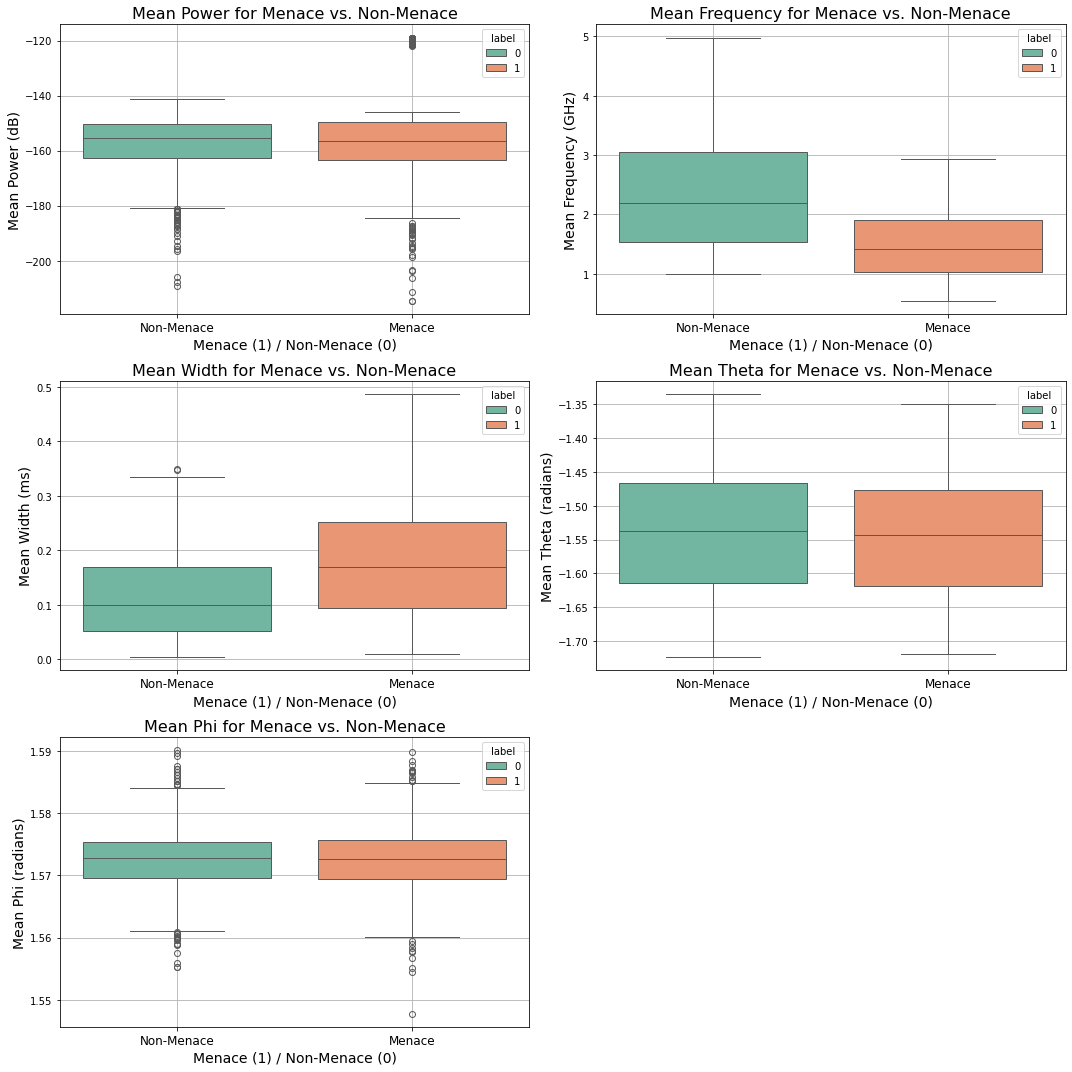

In [251]:
%matplotlib inline
train_path = './radars/train/'
with open('./radars/train_labels.json') as f:
    train_labels = json.load(f)

# Function to compute mean values for various features for each signal
def compute_mean_features(i):
    signal_file = os.path.join(train_path, f'pdw-{i}.npz')
    pdws = np.load(signal_file)
    
    puissances = pdws['puissance']  
    frequences = pdws['frequence']  
    largeurs = pdws['largeur']      
    theta = pdws['theta']           
    phi = pdws['phi']               

    # Compute mean values
    mean_power = np.mean(puissances)
    mean_frequency = np.mean(frequences)
    mean_largeurs = np.mean(largeurs)
    mean_theta = np.mean(theta)
    mean_phi = np.mean(phi)
    
    return mean_power, mean_frequency, mean_largeurs, mean_theta, mean_phi, 1 if train_labels[f'pdw-{i}'] == 'menace' else 0

mean_values = [compute_mean_features(i) for i in range(len(train_labels))]

mean_df = pd.DataFrame(mean_values, columns=['mean_power', 'mean_frequency', 'mean_largeurs', 'mean_theta', 'mean_phi', 'label'])

plt.figure(figsize=(15, 15 ))

plt.subplot(3, 2, 1)
sns.boxplot(x='label', y='mean_power', data=mean_df, palette='Set2',hue='label')
plt.title('Mean Power for Menace vs. Non-Menace', fontsize=16)
plt.xlabel('Menace (1) / Non-Menace (0)', fontsize=14)
plt.ylabel('Mean Power (dB)', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Non-Menace', 'Menace'], fontsize=12)
plt.grid(True)

plt.subplot(3, 2, 2)
sns.boxplot(x='label', y='mean_frequency', data=mean_df, palette='Set2',hue='label')
plt.title('Mean Frequency for Menace vs. Non-Menace', fontsize=16)
plt.xlabel('Menace (1) / Non-Menace (0)', fontsize=14)
plt.ylabel('Mean Frequency (GHz)', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Non-Menace', 'Menace'], fontsize=12)
plt.grid(True)

plt.subplot(3, 2, 3)
sns.boxplot(x='label', y='mean_largeurs', data=mean_df, palette='Set2',hue='label')
plt.title('Mean Width for Menace vs. Non-Menace', fontsize=16)
plt.xlabel('Menace (1) / Non-Menace (0)', fontsize=14)
plt.ylabel('Mean Width (ms)', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Non-Menace', 'Menace'], fontsize=12)
plt.grid(True)

plt.subplot(3, 2, 4)
sns.boxplot(x='label', y='mean_theta', data=mean_df, palette='Set2',hue='label')
plt.title('Mean Theta for Menace vs. Non-Menace', fontsize=16)
plt.xlabel('Menace (1) / Non-Menace (0)', fontsize=14)
plt.ylabel('Mean Theta (radians)', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Non-Menace', 'Menace'], fontsize=12)
plt.grid(True)

plt.subplot(3, 2, 5)
sns.boxplot(x='label', y='mean_phi', data=mean_df, palette='Set2',hue='label')
plt.title('Mean Phi for Menace vs. Non-Menace', fontsize=16)
plt.xlabel('Menace (1) / Non-Menace (0)', fontsize=14)
plt.ylabel('Mean Phi (radians)', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Non-Menace', 'Menace'], fontsize=12)
plt.grid(True)

plt.subplot(3, 2, 6).axis('off')

plt.tight_layout()
plt.show()



Cette figure présente plusieurs boxplots comparant différentes caractéristiques entre deux classes : "Menace" (1) et "Non-Menace" (0) :

**Mean Power for Menace vs. Non-Menace (dB)** : La puissance moyenne semble légèrement inférieure pour les signaux de menace comparée aux non-menaces. Toutefois, la différence n’est pas très marquée, et les deux groupes présentent des distributions similaires avec des étendues comparables. Pour les signaux classés comme menaces, on observe un grand nombre de valeurs aberrantes (avec une très grande puissance), ce qui n'est pas le cas pour les non-menaces. Ainsi, prendre le minimum de la puissance pourrait constituer une bonne caractéristique pour mieux séparer ces signaux (voir la cellule suivante).

**Mean Frequency for Menace vs. Non-Menace (GHz)** : Les signaux de menace ont une fréquence moyenne significativement plus faible que les non-menaces, avec une différence notable entre les médianes. Les non-menaces couvrent une plage de fréquences plus large.

**Mean Width for Menace vs. Non-Menace (ms)** : La largeur moyenne des signaux est globalement plus élevée pour les menaces par rapport aux non-menaces. 

**Mean Theta for Menace vs. Non-Menace (radians)** : Les deux classes présentent des distributions de valeurs de "theta" assez similaires.

**Mean Phi for Menace vs. Non-Menace (radians)** : Ici, les distributions sont très proches, avec peu de différences entre les médianes et les étendues des valeurs pour les deux classes. Cela suggère que cette caractéristique ne distingue pas bien les deux catégories.

**Conclusion** :
Les différences les plus significatives entre les classes apparaissent pour la fréquence moyenne et la largeur moyenne des signaux, tandis que la puissance, "theta", et "phi" montrent des similarités plus prononcées.

Mean Freq, Mean width, Min power, Mean Power/min power, 1/freq, std(1/freq), np.std(inverse_frequency)/np.mean(inverse_frequency) ,

### 1 - Min Puissance

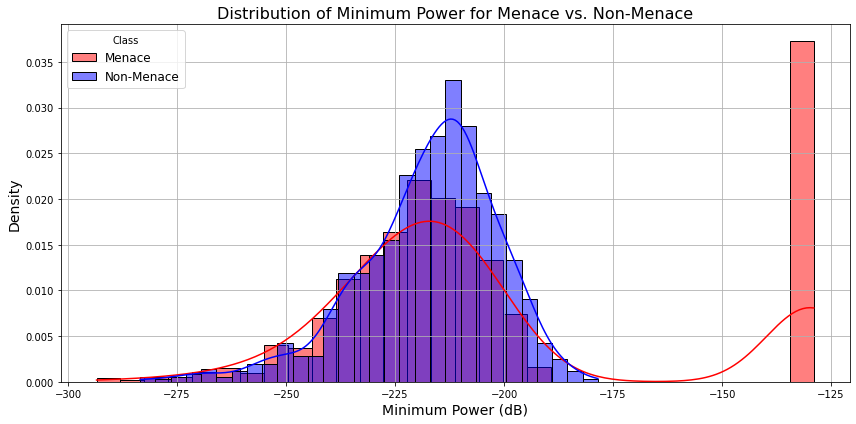

In [252]:
def compute_min_power(i):
    signal_file = os.path.join(train_path, f'pdw-{i}.npz')
    pdws = np.load(signal_file)
    puissances = pdws['puissance']  
    min_power = np.min(puissances)

    return min_power, 1 if train_labels[f'pdw-{i}'] == 'menace' else 0

min_power_values = [compute_min_power(i) for i in range(len(train_labels))]
min_power_df = pd.DataFrame(min_power_values, columns=['min_power', 'label'])

plt.figure(figsize=(12, 6))
sns.histplot(min_power_df[min_power_df['label'] == 1]['min_power'], 
             bins=30, color='red', label='Menace', kde=True, stat='density', alpha=0.5)
sns.histplot(min_power_df[min_power_df['label'] == 0]['min_power'], 
             bins=30, color='blue', label='Non-Menace', kde=True, stat='density', alpha=0.5)
plt.title('Distribution of Minimum Power for Menace vs. Non-Menace', fontsize=16)
plt.xlabel('Minimum Power (dB)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Class', fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

Bien que les deux distributions se chevauchent, on remarque qu'il y a un grand nombre de signaux classés comme menaces ayant une valeur de puissance très élevée (vers -130 dB).

### 2 - L'écart type de l'inverse de la fréquence

L'écart type quantifie la dispersion des valeurs de 1/f. Un écart type élevé indique que les périodes des cycles des signaux varient beaucoup, tandis qu'un écart type faible signifie que les périodes sont relativement constantes.

les sginaux Non-menaces : Les objets non menaçants, comme des objets statiques ou se déplaçant de manière régulière, auraient probablement des périodes plus stables, ce qui se traduit par un écart type plus faible.

les signaux menaçants peuvent avoir une variabilité plus grande dans leurs périodes (une forte variabilité des longueurs d'onde), ce qui peut être le signe de comportements erratiques ou imprévisibles d'un objet. 

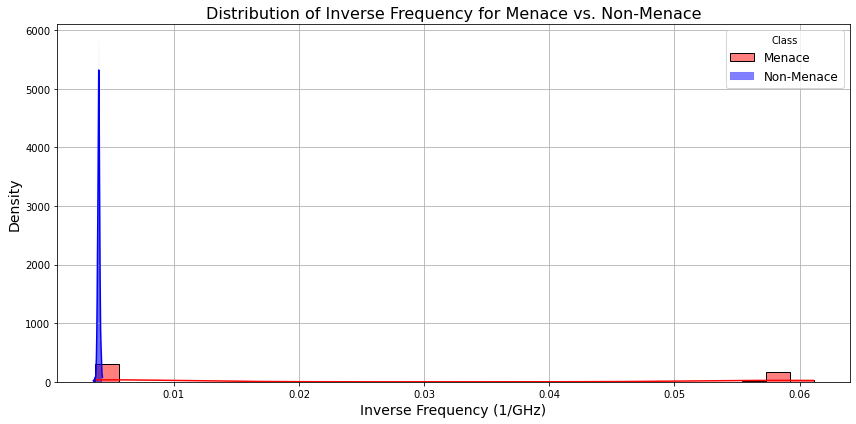

In [269]:
# Function to compute 1/frequency and related label
def compute_inverse_frequency(i):
    signal_file = os.path.join(train_path, f'pdw-{i}.npz')
    pdws = np.load(signal_file)
    frequences = pdws['frequence']  
    inverse_frequency = 1 / frequences[frequences > 0]  # Ensure no division by zero
    return np.std(inverse_frequency)/np.mean(inverse_frequency), 1 if train_labels[f'pdw-{i}'] == 'menace' else 0

inverse_frequency_values = [compute_inverse_frequency(i) for i in range(len(train_labels))]
inverse_freq_df = pd.DataFrame(inverse_frequency_values, columns=['inverse_frequency', 'label'])


plt.figure(figsize=(12, 6))
sns.histplot(inverse_freq_df[inverse_freq_df['label'] == 1]['inverse_frequency'], 
             bins=30, color='red', label='Menace', kde=True, stat='density', alpha=0.5)
sns.histplot(inverse_freq_df[inverse_freq_df['label'] == 0]['inverse_frequency'], 
             bins=30, color='blue', label='Non-Menace', kde=True, stat='density', alpha=0.5)
plt.title('Distribution of Inverse Frequency for Menace vs. Non-Menace', fontsize=16)
plt.xlabel('Inverse Frequency (1/GHz)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Class', fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()


Cette figure montre la distribution de l'inverse de la fréquence pour les classes Menace (en rouge) et Non-Menace (en bleu). La majorité des valeurs pour la classe Non-Menace sont concentrées très près de zéro, indiquant que les signaux de non-menace ont généralement des fréquences plus élevées (car l'inverse est faible). En revanche, la distribution des Menaces est beaucoup plus dispersée, avec quelques valeurs d'inverse de la fréquence qui s'étendent davantage, ce qui suggère que les signaux de menace sont associés à des fréquences plus basses. Les deux distributions sont distinctes, **ce qui signifie que l'inverse de la fréquence pourrait être une caractéristique discriminante pour différencier les menaces des non-menaces.**

### 3 - Variance des angles Theta et Phi

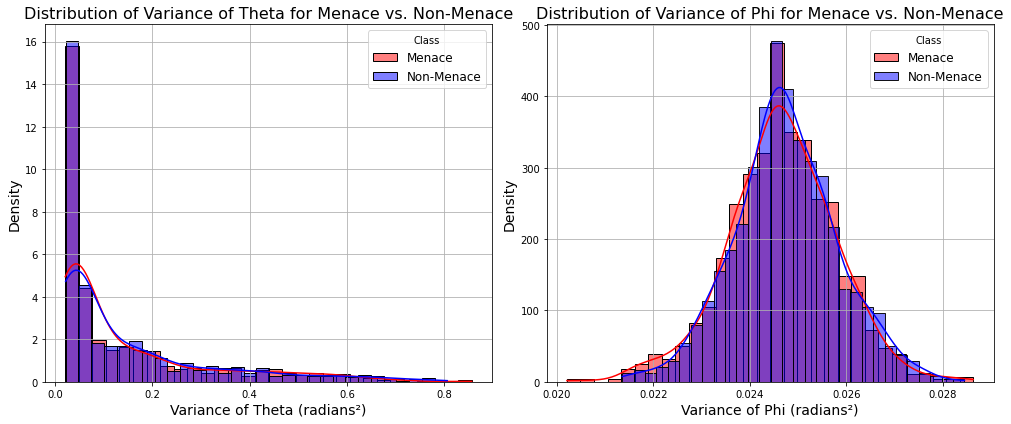

In [255]:
def compute_variance_theta_phi(i):
    signal_file = os.path.join(train_path, f'pdw-{i}.npz')
    pdws = np.load(signal_file)
    theta = pdws['theta']  
    phi = pdws['phi']      
    variance_theta = np.var(theta)
    variance_phi = np.var(phi)
    return variance_theta, variance_phi, 1 if train_labels[f'pdw-{i}'] == 'menace' else 0

theta_phi_variances = [compute_variance_theta_phi(i) for i in range(len(train_labels))]
theta_phi_df = pd.DataFrame(theta_phi_variances, columns=['variance_theta', 'variance_phi', 'label'])

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(theta_phi_df[theta_phi_df['label'] == 1]['variance_theta'], 
             bins=30, color='red', label='Menace', kde=True, stat='density', alpha=0.5)

sns.histplot(theta_phi_df[theta_phi_df['label'] == 0]['variance_theta'], 
             bins=30, color='blue', label='Non-Menace', kde=True, stat='density', alpha=0.5)
plt.title('Distribution of Variance of Theta for Menace vs. Non-Menace', fontsize=16)
plt.xlabel('Variance of Theta (radians²)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Class', fontsize=12)
plt.grid(True)
plt.subplot(1, 2, 2)
sns.histplot(theta_phi_df[theta_phi_df['label'] == 1]['variance_phi'], 
             bins=30, color='red', label='Menace', kde=True, stat='density', alpha=0.5)

sns.histplot(theta_phi_df[theta_phi_df['label'] == 0]['variance_phi'], 
             bins=30, color='blue', label='Non-Menace', kde=True, stat='density', alpha=0.5)
plt.title('Distribution of Variance of Phi for Menace vs. Non-Menace', fontsize=16)
plt.xlabel('Variance of Phi (radians²)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Class', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


Ces figures montrent que les distributions de la variance de Theta et de la variance de Phi se ressemblent fortement pour les classes Menace et Non-Menace. Pour Theta, la majorité des valeurs sont proches de zéro pour les deux classes, avec seulement une légère différence dans la queue de la distribution. Pour Phi, les distributions sont quasiment identiques, **ce qui montre que la variance de ces deux caractéristiques n'est pas particulièrement discriminante entre menace et non-menace.**

### 4 - L'écart type de la largeur

L'écart type de la largeur des impulsions représente la variabilité ou la dispersion des largeurs d'impulsions dans un signal. Si l'écart type est élevé, cela indique qu'il y a une grande variation dans les largeurs des impulsions : certaines impulsions sont très larges, d'autres sont très étroites. À l'inverse, un écart type faible signifie que les largeurs des impulsions sont relativement constantes et ne varient pas beaucoup.

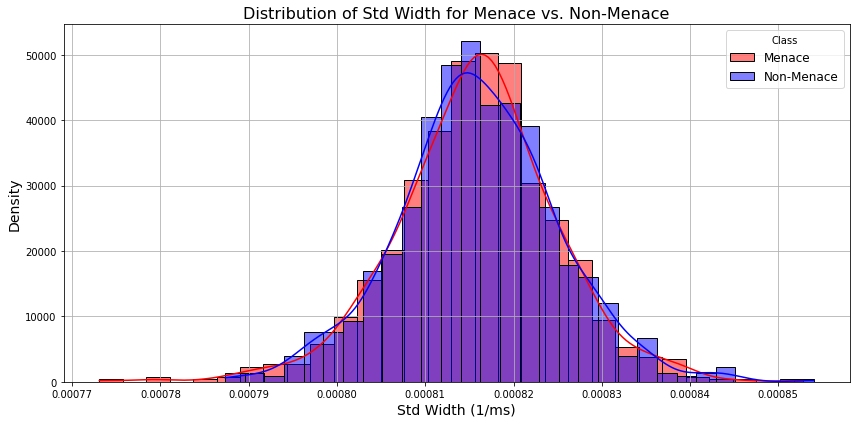

In [273]:
def compute_inverse_width(i):
    signal_file = os.path.join(train_path, f'pdw-{i}.npz')
    pdws = np.load(signal_file)
    largeurs = pdws['largeur']  
    inverse_width = largeurs[largeurs > 0]  
    return np.std(inverse_width), 1 if train_labels[f'pdw-{i}'] == 'menace' else 0

inverse_width_values = [compute_inverse_width(i) for i in range(len(train_labels))]
inverse_width_df = pd.DataFrame(inverse_width_values, columns=['inverse_width', 'label'])

plt.figure(figsize=(12, 6))
sns.histplot(inverse_width_df[inverse_width_df['label'] == 1]['inverse_width'], 
             bins=30, color='red', label='Menace', kde=True, stat='density', alpha=0.5)

sns.histplot(inverse_width_df[inverse_width_df['label'] == 0]['inverse_width'], 
             bins=30, color='blue', label='Non-Menace', kde=True, stat='density', alpha=0.5)
plt.title('Distribution of Std Width for Menace vs. Non-Menace', fontsize=16)
plt.xlabel('Std Width (1/ms)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Class', fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

Cette figure montre la distribution de l'écart-type de la largeur (Std Width) pour les classes Menace (rouge) et Non-Menace (bleu). Les deux distributions sont presque superposées, avec des pics similaires autour de 0.00081 1/ms. **Cela indique que la variabilité des largeurs des impulsions est comparable entre les menaces et les non-menaces, suggérant que l'écart-type de la largeur n'est pas particulièrement discriminant pour séparer les deux classes.** Quelques différences mineures apparaissent dans les queues des distributions, mais elles ne sont pas assez prononcées pour permettre une distinction claire.

# Préparation des données

La fonction `compute_features` permet d'extraire et de calculer des caractéristiques spécifiques d'un signal radar à partir d'un fichier de données. Elle charge les données du signal, qui incluent les fréquences, les largeurs d'impulsion et les puissances, et calcule plusieurs caractéristiques dérivées. Parmi ces caractéristiques, on retrouve la moyenne des fréquences (`mean_frequency`), la moyenne des largeurs d'impulsion (`mean_width`), la puissance minimale (`min_power`), ainsi que le rapport entre la puissance moyenne et la puissance minimale (`mean_power_to_min_power`). La fonction calcule également l'inverse des fréquences pour déterminer l'écart type et la moyenne de ces inverses, ce qui permet d'obtenir des informations sur la variabilité et la stabilité du signal. Enfin, elle associe chaque signal à une classe (menace ou non) en fonction des étiquettes fournies, afin de faciliter l'utilisation de ces caractéristiques pour des tâches de classification.


- `'mean_frequency'` : La fréquence moyenne.
- `'mean_width'` : La largeur moyenne.
- `'min_power'` : La puissance minimale.
- `'mean_power_to_min_power'` : Le ratio de la puissance moyenne à la puissance minimale.
- `'inverse_frequency'` : L'inverse de la fréquence.
- `'std_inverse_frequency'` : L'écart type de l'inverse de la fréquence.
- `'ratio_std_mean_inverse'` : Coefficient de variation de la fréquence.



In [257]:
def compute_features(i,path):
    signal_file = os.path.join(path, f'pdw-{i}.npz')
    pdws = np.load(signal_file)
    frequences = pdws['frequence']  
    largeurs = pdws['largeur']      
    puissances = pdws['puissance']  

    mean_frequency = np.mean(frequences)
    mean_width = np.mean(largeurs)
    min_power = np.min(puissances)
    mean_power = np.mean(puissances)
    mean_power_to_min_power = mean_power / min_power if min_power != 0 else np.inf
    inverse_frequency = 1 / frequences[frequences > 0]  # Avoid division by zero
    std_inverse_frequency = np.std(inverse_frequency)
    mean_inverse_frequency = np.mean(inverse_frequency)
    ratio_std_mean_inverse = std_inverse_frequency / mean_inverse_frequency if mean_inverse_frequency != 0 else np.inf

    label = 1 if train_labels[f'pdw-{i}'] == 'menace' else 0

    return [mean_frequency, mean_width, min_power, mean_power_to_min_power, 
            1/mean_frequency if mean_frequency > 0 else np.inf, 
            std_inverse_frequency, 
            ratio_std_mean_inverse,label]

feature_values = []

for i in range(len(train_labels)):
    features = compute_features(i,train_path)
    feature_values.append(features)

# Create a DataFrame from the feature values
feature_df = pd.DataFrame(feature_values, columns=[
    'mean_frequency', 'mean_width', 'min_power', 
    'mean_power_to_min_power', 'inverse_frequency', 
    'std_inverse_frequency', 'ratio_std_mean_inverse', 
    'label'])



In [258]:
# Separate features and labels
X = feature_df.drop(columns='label')
y = feature_df['label']

Ce code normalise les caractéristiques en utilisant `StandardScaler` pour les centrer autour de zéro et les mettre à l'échelle. Ensuite, il calcule et visualise la matrice de corrélation entre les caractéristiques sous forme de carte thermique. Cela permet d'identifier les relations linéaires entre les caractéristiques, facilitant ainsi la sélection de celles qui sont redondantes ou particulièrement informatives pour les modèles de classification.



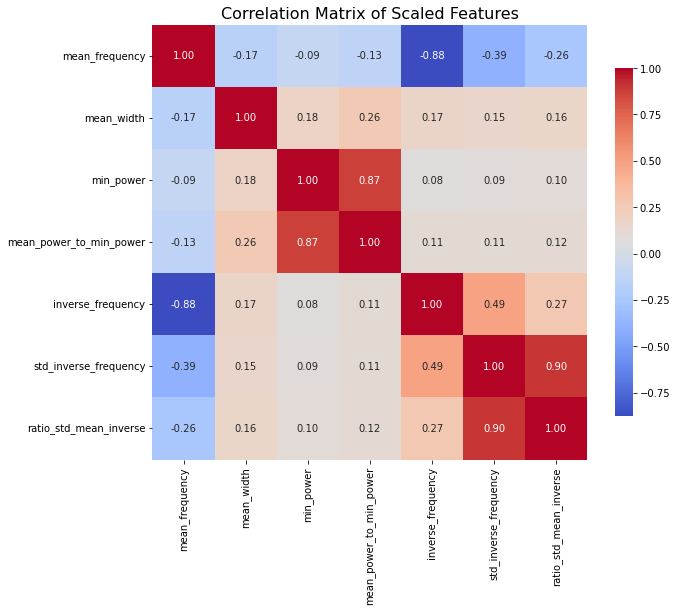

In [259]:
from sklearn.preprocessing import StandardScaler
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Calculate the correlation matrix
correlation_matrix = X.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Scaled Features', fontsize=16)
plt.show()

Cette matrice de corrélation montre que l'inverse de la fréquence est fortement corrélée négativement à la fréquence moyenne, ce qui est attendu étant donné leur relation inverse. De plus, la puissance minimale et le rapport mean power to min power ont une forte corrélation positive, indiquant qu'ils capturent des aspects similaires du signal. Enfin, il y a une forte corrélation entre le std inverse frequency et le ratio std mean inverse, tandis que la plupart des autres caractéristiques présentent des corrélations faibles, suggérant qu'elles apportent des informations complémentaires sans redondance significative

In [260]:
X = X.drop("std_inverse_frequency", axis=1)

# Modèles de Classification

### Baseline de référence : Logistic Regression

On évalue la performance d'un modèle de régression logistique à l'aide de la validation croisée à 5 folds sur les données `X` et `y`. Les scores de précision pour chaque fold sont affichés, ainsi que la moyenne des scores.

In [274]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)
cv_scores = cross_val_score(log_reg, X, y, cv=5)  # 5-fold cross-validation

print(f'Cross-validation scores: {cv_scores}')
print(f'Mean CV accuracy: {cv_scores.mean():.2f}')

Cross-validation scores: [0.8    0.83   0.835  0.81   0.8275]
Mean CV accuracy: 0.82


Pour ce modèle de référence, nous obtenons une valeur d'accuracy de 0.82. 

### Sélection du modèle de classification

On a choisi de travailler avec les modèles de calssification suivantes : **KNN** (K Nearst Neighbors), **RandomForest**, **SVM** (Support Vector Machine), **XGBoost** (Extreme Gradient Boosting).

Pour chaque modèle, on test une combinaison des hyperparamètres (Grid Search) pour trouver le modèle qui donne la meilleure accuracy de validation, en utilisant la méthode de la validation croisée.

In [262]:
# Hyperparameter grid for KNN
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt']  
}

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
}

svm_param_grid = {
    'C': [0.1, 1, 10],           
    'kernel': ['linear', 'rbf'],  
    'gamma': ['scale', 'auto'],   
}




In [263]:
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


# XGBoost
model_xgb = xgb.XGBClassifier(objective='binary:logistic')
xgb_grid_search = GridSearchCV(estimator=model_xgb, param_grid=xgb_param_grid, scoring='accuracy', cv=5)
xgb_grid_search.fit(X, y)

xgb_best_model = xgb_grid_search.best_estimator_

print("Best parameters for xgboost:", xgb_grid_search.best_params_)
print("Best cross-validation score for xgboost:", xgb_grid_search.best_score_)


# KNN
knn = KNeighborsClassifier()
knn_grid_search = GridSearchCV(knn, knn_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
knn_grid_search.fit(X, y)

print("Best parameters for KNN:", knn_grid_search.best_params_)
print("Best cross-validation score for KNN:", knn_grid_search.best_score_)

# Random Forest
rf = RandomForestClassifier()
rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(X, y)

print("Best parameters for Random Forest:", rf_grid_search.best_params_)
print("Best cross-validation score for Random Forest:", rf_grid_search.best_score_)


# SVM
model_SVM = SVC()
SVM_grid_search = GridSearchCV(estimator=model_SVM, param_grid=svm_param_grid, scoring='accuracy', cv=5)
SVM_grid_search.fit(X, y)
SVM_best_model = SVM_grid_search.best_estimator_

print("Best parameters for SVM:", SVM_grid_search.best_params_)
print("Best cross-validation score for SVM:", SVM_grid_search.best_score_)

Best parameters for xgboost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best cross-validation score for xgboost: 0.8480000000000001
Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
Best cross-validation score for KNN: 0.8380000000000001
Best parameters for Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation score for Random Forest: 0.853
Best parameters for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score for SVM: 0.851


| Modèle d'entraînement                | Validation Accuracy (%) |
|--------------------------------------|--------------|
| Régression Logistique (Baseline)               | 82.7         |
| SVM (Support Vector Machine)         | 85.1         |
| **Random Forest**                        | **85.3**         |
| K-Nearest Neighbors (KNN)            | 83.8         |
| Gradient Boosting                    | 84.8         |

**Commentaire**: Random Forest présente une meilleure validation accuracy 85.3%

# Évaluation des performances des modèles sur la base test

On prépare la base test :

In [264]:
test_path = './radars/test/'
with open('./radars/test_labels.json') as f:
    test_labels = json.load(f)

feature_values_test = []
for i in range(len(test_labels)):
    features = compute_features(i,test_path)
    feature_values_test.append(features)

feature_df_test = pd.DataFrame(feature_values_test, columns=[
    'mean_frequency', 'mean_width', 'min_power', 
    'mean_power_to_min_power', 'inverse_frequency', 
    'std_inverse_frequency', 'ratio_std_mean_inverse', 
    'label'])

X_test = feature_df.drop(columns='label')
y_test = feature_df['label']
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_test = X_test.drop("std_inverse_frequency", axis=1)


### Comparaison des modèles 

In [276]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Evaluate KNN
best_knn = knn_grid_search.best_estimator_
y_pred_knn = best_knn.predict(X_test)

print("\nKNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

# Evaluate XGBoost
y_pred_xgb = xgb_best_model.predict(X_test)

print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# Evaluate SVM
y_pred_SVM = SVM_best_model.predict(X_test)

print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_SVM))

# Evaluate Random Forest
best_rf = rf_grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))






KNN Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1011
           1       0.92      0.84      0.88       989

    accuracy                           0.88      2000
   macro avg       0.89      0.88      0.88      2000
weighted avg       0.89      0.88      0.88      2000


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      1011
           1       0.94      0.78      0.85       989

    accuracy                           0.87      2000
   macro avg       0.88      0.87      0.87      2000
weighted avg       0.88      0.87      0.87      2000


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.95      0.87      1011
           1       0.94      0.75      0.83       989

    accuracy                           0.85      2000
   macro avg       0.87      0.85      0

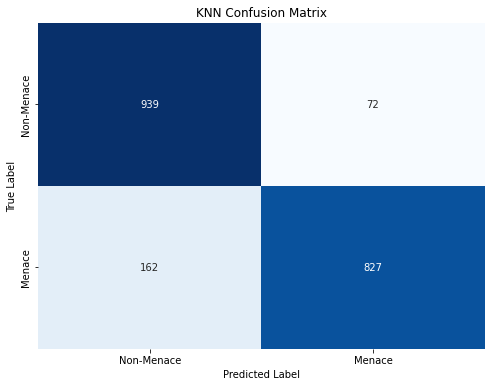

KNN Accuracy: 0.883


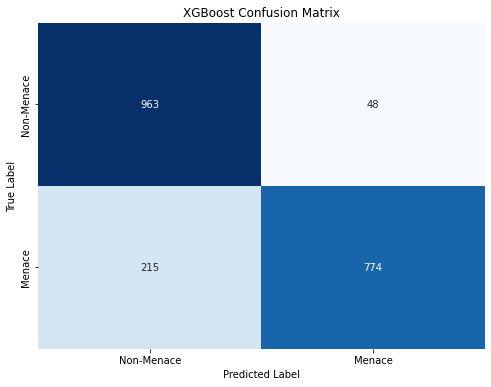

XGBoost Accuracy: 0.8685


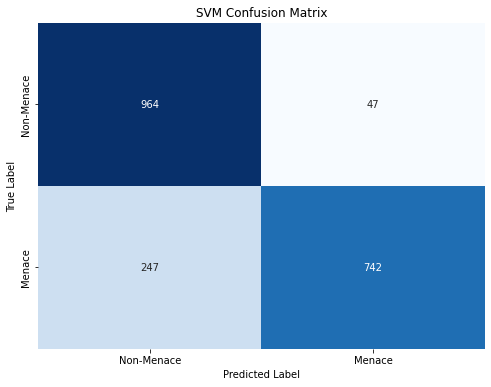

SVM Accuracy: 0.853


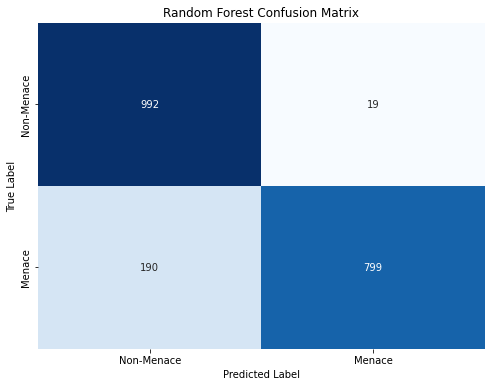

Random Forest Accuracy: 0.8955


In [277]:
# Plotting confusion matrices
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non-Menace', 'Menace'],
                yticklabels=['Non-Menace', 'Menace'])
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Confusion Matrix for KNN
knn_cm = confusion_matrix(y_test, y_pred_knn)
plot_confusion_matrix(knn_cm, title='KNN Confusion Matrix')
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))


# Confusion Matrix for XGBoost
xgb_cm = confusion_matrix(y_test, y_pred_xgb)
plot_confusion_matrix(xgb_cm, title='XGBoost Confusion Matrix')
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))


# Confusion Matrix for SVM
SVM_cm = confusion_matrix(y_test, y_pred_SVM)
plot_confusion_matrix(SVM_cm, title='SVM Confusion Matrix')
print("SVM Accuracy:", accuracy_score(y_test, y_pred_SVM))


# Confusion Matrix for Random Forest
rf_cm = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(rf_cm, title='Random Forest Confusion Matrix')
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))


| Modèle d'entraînement                | Test Accuracy (%) |
|--------------------------------------|--------------|
| SVM (Support Vector Machine)         | 85.30         |
| **Random Forest**                    | **89.55**         |
| K-Nearest Neighbors (KNN)            | 88.30         |
| Gradient Boosting                    | 86.85         |

### Interprétation de notre meilleur modèle : RandomForest

On extrait et visualise l'importance des caractéristiques (features) de notre modèle Random Forest. On commence par récupérer les valeurs d'importance des caractéristiques à partir du modèle entraîné. Ceci permet d'illustrer les importances des caractéristiques, permettant ainsi d'identifier celles qui ont le plus d'impact sur la classification.


/tmp/ipykernel_27610/2794121495.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


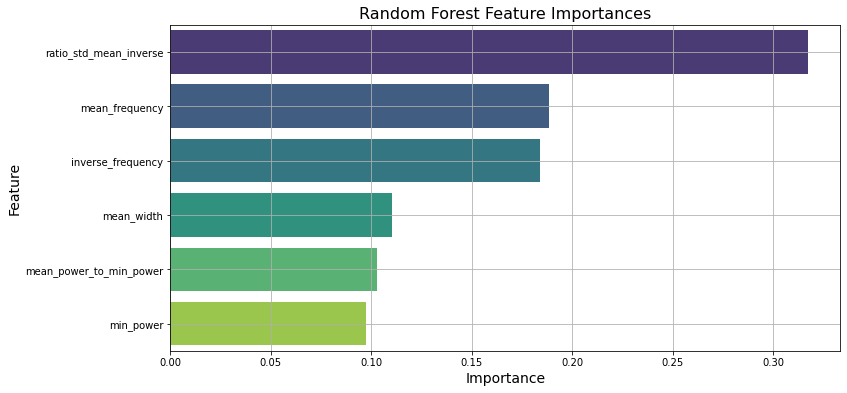

In [267]:
feature_importances = best_rf.feature_importances_

feature_names = X.columns  
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Random Forest Feature Importances', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.grid(True)
plt.show()

Ce graphique montre l'importance des caractéristiques pour notre modèle de Random Forest. La caractéristique la plus importante est le **Coefficient de variation de la fréquence** (ratio_std_mean_inverse), suivie de la fréquence moyenne (mean_frequency) et de l'inverse de la fréquence (inverse_frequency), ce qui indique que les fréquences et leur variance jouent un rôle clé dans la capacité du modèle à distinguer les classes. Les autres caractéristiques ont une importance moindre, mais elles contribuent également à la performance du modèle. ****Cela suggère que les caractéristiques liées aux fréquences sont les plus discriminantes dans ce modèle.****

**Résumé:** 

Dans ce travail, le choix des caractéristiques discriminantes n'était pas évident avec une première analyse des données, une étude approfondie a donc été réalisée. Ensuite, nous avons sélectionné les caractéristiques les plus pertinentes, telles que l'inverse de la fréquence, le minimum d'énergie, etc. Nous avons ensuite comparé différents modèles de classification en nous basant sur les caractéristiques sélectionnées. Les modèles de classification ont été évalués puis testés en utilisant la base de données de test. L'étude nous a montré que le modèle Random Forest est celui qui offre la meilleure précision (accuracy) à la fois en validation croisée et sur la base de test.